In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Define image dimensions
img_height, img_width = 128, 128

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Apply rescaling to validation and testing data as well
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Baseline_protocol/train',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Baseline_protocol/validation',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='binary'
)
validation_generator.shuffle = False

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Baseline_protocol/test',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='binary'
)


Found 4320 images belonging to 2 classes.
Found 2880 images belonging to 2 classes.
Found 7200 images belonging to 2 classes.


In [4]:

# Model Definition and Training
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10)


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
68/68 [==============================] - 1429s 20s/step - loss: 0.0876 - accuracy: 0.9725
Epoch 2/10
68/68 [==============================] - 40s 584ms/step - loss: 0.0140 - accuracy: 0.9954
Epoch 3/10
68/68 [==============================] - 40s 594ms/step - loss: 0.0093 - accuracy: 0.9977
Epoch 4/10
68/68 [==============================] - 40s 593ms/step - loss: 0.0155 - accuracy: 0.9981
Epoch 5/10
68/68 [==============================] - 40s 585ms/step - loss: 0.0056 - accuracy: 0.9977
Epoch 6/10
68/68 [==============================] - 40s 587ms/step - loss: 0.0033 - accuracy: 0.9984
Epoch 7/10
68/68 [==============================] - 40s 591ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch 8/10
68/68 [==============================] - 40s 585ms/step - loss: 0.0094 - accuracy: 0.9965
Epoch 9/10
68/68 [==============================] - 40s 585ms/step - loss: 0.0029 - accuracy: 0.9993
Epoch 10/10
68/68 [=======

In [5]:
# Calculate the length of the test generator
test_steps = len(test_generator)

# Set shuffle=False for the test generator
test_generator.shuffle = False

# Evaluate the model using the test generator with the batch size equal to the test generator length
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")


113/113 [==============================] - 4834s 43s/step - loss: 0.8310 - accuracy: 0.6779
Test loss: 0.8310, Test accuracy: 0.6779


113/113 [==============================] - 35s 304ms/step
True Positives: 2801
False Positives: 1520
True Negatives: 2080
False Negatives: 799
Accuracy: 0.6779
APCER: 0.4222
BPCER: 0.2219


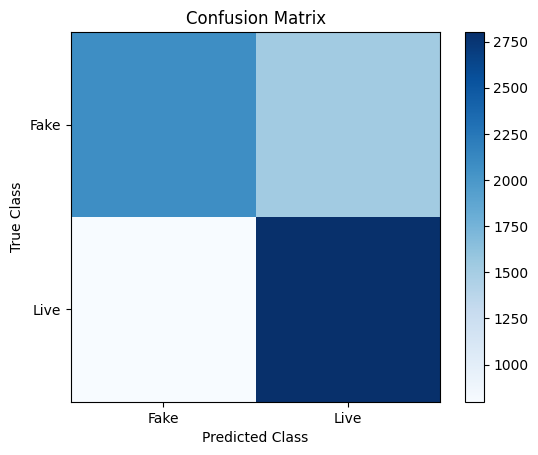

              precision    recall  f1-score   support

        Fake       0.72      0.58      0.64      3600
        Live       0.65      0.78      0.71      3600

    accuracy                           0.68      7200
   macro avg       0.69      0.68      0.67      7200
weighted avg       0.69      0.68      0.67      7200



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for test data
y_pred = model.predict(test_generator)

threshold = 0.5

# Convert probabilities to binary class predictions using threshold
y_pred_classes = (y_pred>= threshold).astype(int)

y_true = test_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Extract TP, FP, TN, FN
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
apcer = FP / (FP + TN)
bpcer = FN / (FN + TP)

# Print metrics
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"BPCER: {bpcer:.4f}")

# Display confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks([0, 1], ['Fake', 'Live'])
plt.yticks([0, 1], ['Fake', 'Live'])
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Fake', 'Live']))

In [8]:
import pandas as pd

data = pd.DataFrame({'y_true': y_true, 'y_pred_class_1': y_pred[:, 0]})

# Specify the full path to your desired directory in Google Drive
google_drive_path = '/content/drive/MyDrive/Baseline_protocol/'

# Specify the CSV filename
csv_filename = 'resnet50_predictions.csv'

# Save the DataFrame to a CSV file in the Google Drive directory
# Use float_format to control the formatting of floating-point numbers
data.to_csv(google_drive_path + csv_filename, index=False)  # Adjust the precision as needed

print(f"CSV file saved to: {google_drive_path + csv_filename}")

CSV file saved to: /content/drive/MyDrive/Baseline_protocol/resnet50_predictions.csv


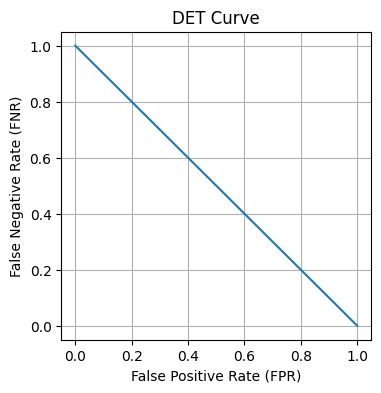

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for different thresholds
thresholds = np.arange(0, 1.01, 0.01)  # You can adjust the range and step size
fpr_list = []
fnr_list = []

for threshold in thresholds:
    y_pred_classes = (y_pred>= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred_classes == 1))
    fp = np.sum((y_true == 0) & (y_pred_classes == 1))
    fn = np.sum((y_true == 1) & (y_pred_classes == 0))
    tn = np.sum((y_true == 0) & (y_pred_classes == 0))

    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    fpr_list.append(fpr)
    fnr_list.append(fnr)

# Plot DET curve
plt.figure(figsize=(4, 4))
plt.plot(fpr_list, fnr_list)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('DET Curve')
plt.grid(True)
plt.show()

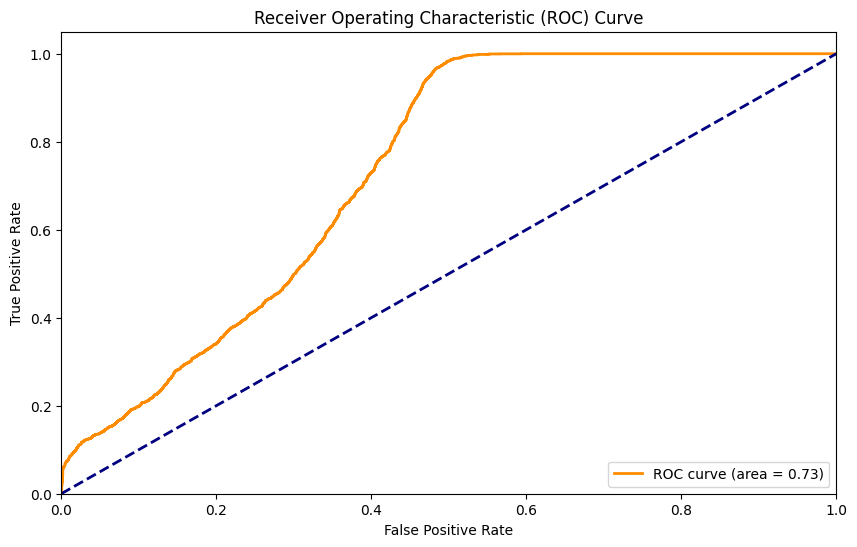

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have y_pred and y_true already defined
y_scores = y_pred  # Probabilities of belonging to class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
